In [1]:
!pip install scipy==1.2.1

     |████████████████████████████████| 24.8MB 127kB/s 
ERROR: umap-learn 0.4.6 has requirement scipy>=1.3.1, but you'll have scipy 1.2.1 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement scipy==1.4.1, but you'll have scipy 1.2.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [2]:
!pip install -q imageio

In [3]:
import tensorflow as tf

In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [7]:
(train_images_1, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

In [8]:
train_images_1.shape

(50000, 32, 32, 3)

In [69]:
train_images_new = train_images_1[:100]

In [70]:
train_images_new.shape

(100, 32, 32, 3)

In [71]:
from scipy.misc import imresize
from numpy import array

In [72]:
#convert training images to low resolution to feed to the generator network
def lr_images(images_real , downscale):
    
    images = []
    for img in  range(len(images_real)):
        images.append(imresize(images_real[img], [images_real[img].shape[0]//downscale,images_real[img].shape[1]//downscale], interp='bicubic', mode=None))
    images_lr = array(images)
    return images_lr

In [16]:
x_train_lr = lr_images(train_images_1, 4)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


In [17]:
print(x_train_lr.shape)

(50000, 8, 8, 3)


In [73]:
x_train_lr_new  = x_train_lr.reshape(-1,32,32,3) 
train_images_newest = train_images_new.reshape(-1,32,32,3)

In [74]:
train_images = (train_images_new - 127.5) / 127.5 # Normalize the discriminator images to [-1, 1]
x_train_lr  = (x_train_lr_new - 127.5) / 127.5 # Normalize the generator images to [-1, 1]
print(train_images.shape)
print(x_train_lr.shape)

(100, 32, 32, 3)
(3125, 32, 32, 3)


In [75]:
x_train_lr_neu = x_train_lr[:100]

In [76]:
x_train_lr_neu.shape

(100, 32, 32, 3)

In [46]:
BUFFER_SIZE = 60000
BATCH_SIZE = 10

In [23]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(100, use_bias=False, input_shape=(32,32,3)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((32,32,100)))
    assert model.output_shape == (None, 32,32,100) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    #assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    model.add(layers.Reshape((32,32,3)))
    assert model.output_shape == (None, 32, 32, 3)
    print(model.output_shape)
    print(model.summary)
    return model

In [47]:
make_generator_model().summary()

(None, 32, 32, 3)
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f5ab1a0bac8>>
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32, 32, 100)       300       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 100)       400       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 32, 32, 100)       0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 32, 32, 100)       0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 32, 32, 128)       320000    
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 128)       5

In [48]:
generator = make_generator_model()

(None, 32, 32, 3)
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f5ab1fb7400>>


In [49]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[32,32,3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [50]:
make_discriminator_model().summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)             

In [51]:
discriminator = make_discriminator_model()

In [52]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [53]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [54]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [55]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [56]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 discriminator=discriminator,
                                 generator=generator
                                 )

In [63]:
#@tf.function
def train_step(images):
    #noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(x_train_lr_neu, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [58]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             x_train_lr_neu)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           x_train_lr_neu)

In [82]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(30,30))

  for i in range(predictions.shape[0]):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, :] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [77]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_dataset)

<BatchDataset shapes: (None, 32, 32, 3), types: tf.float64>


In [78]:
print(train_images.shape)

(100, 32, 32, 3)


In [79]:
EPOCHS = 10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

ValueError: ignored

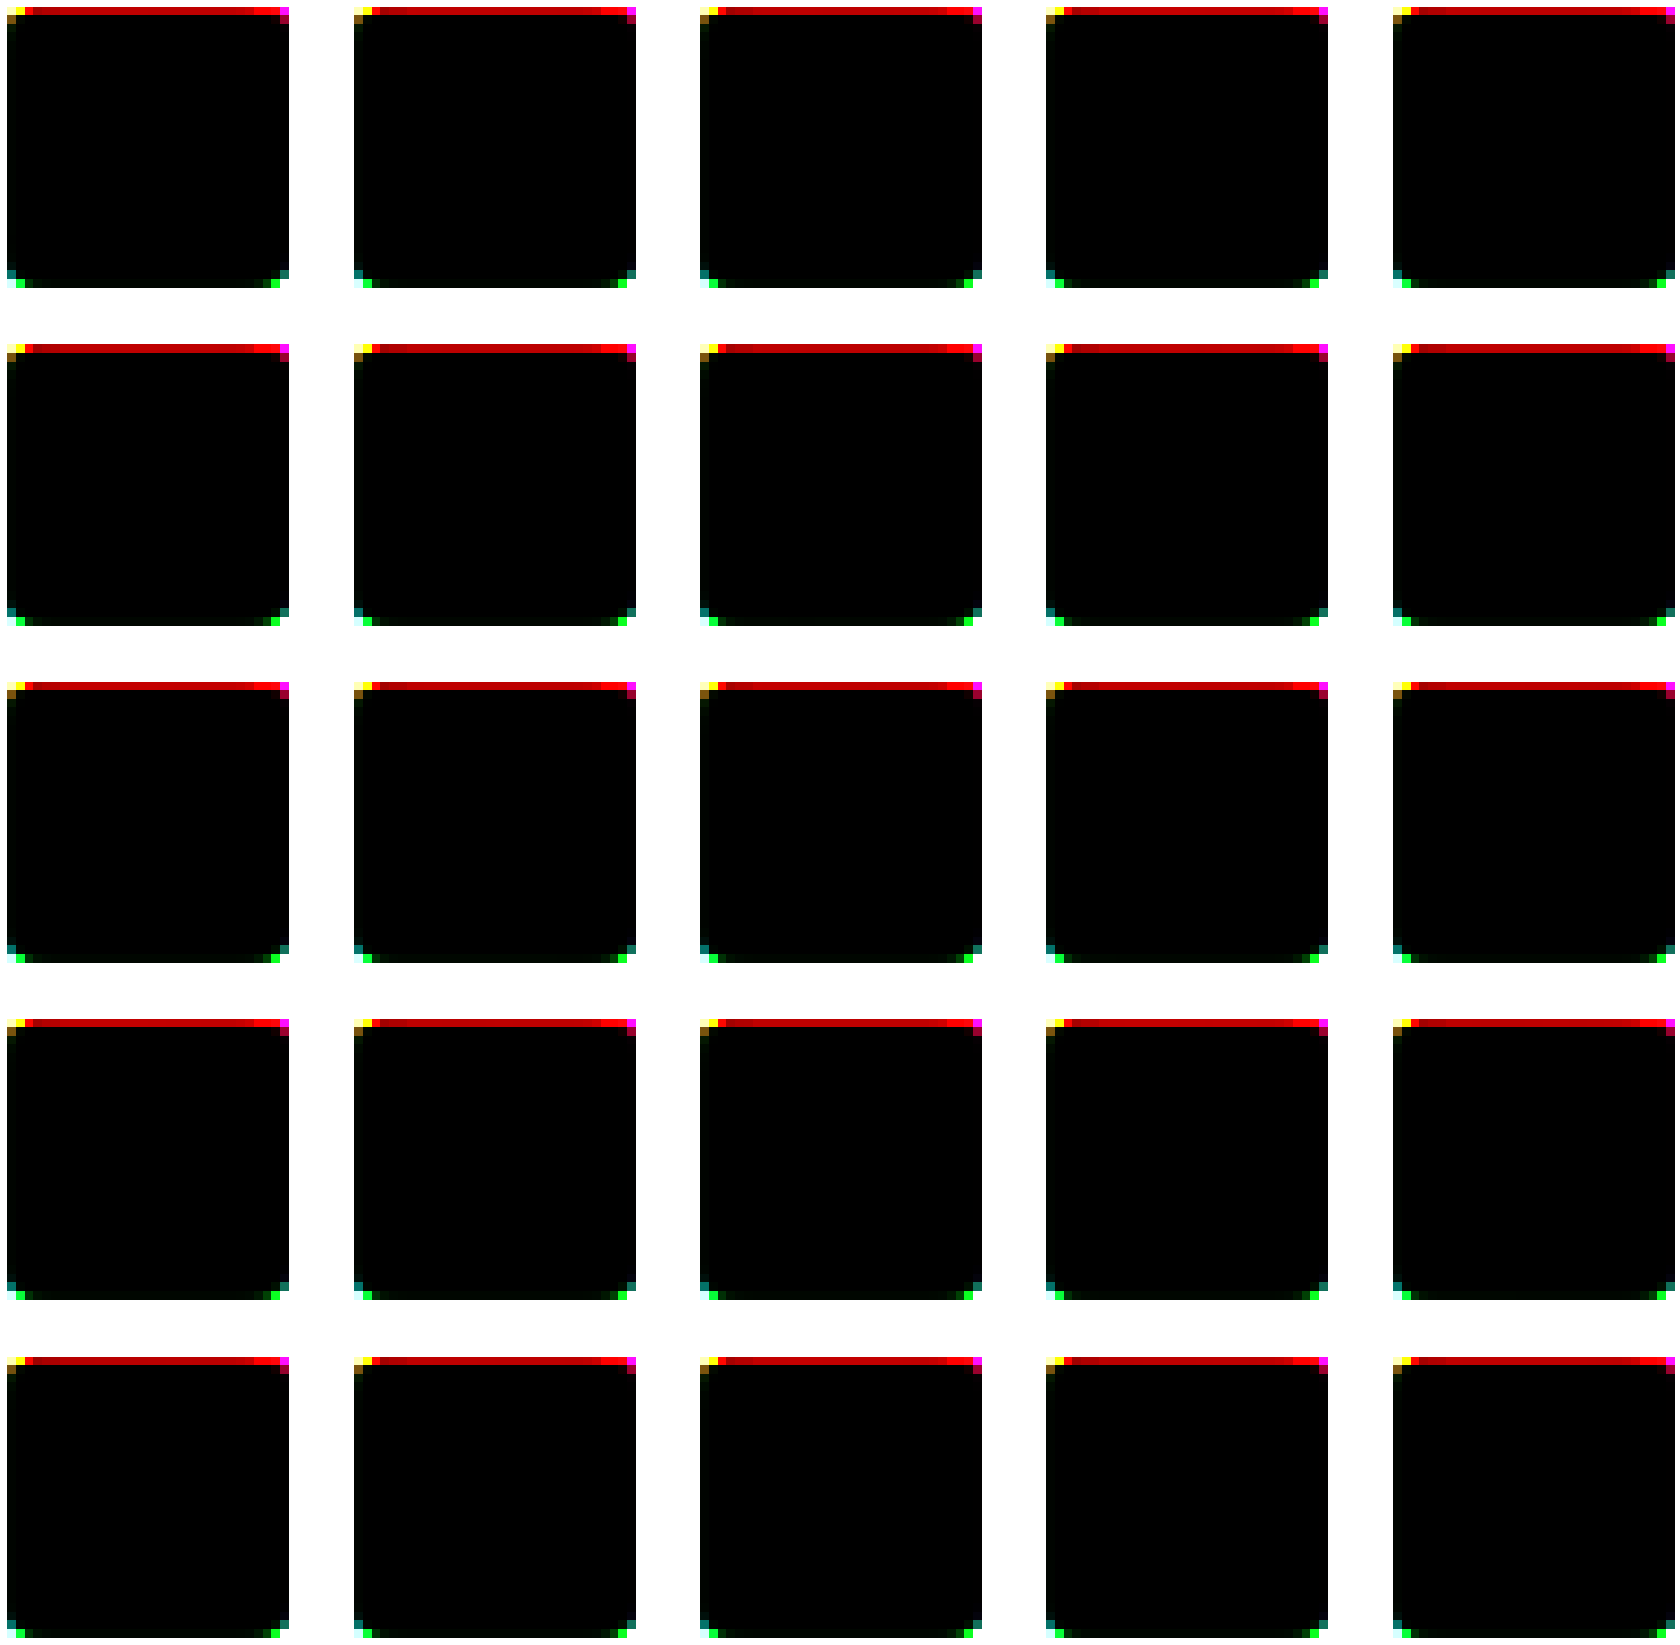

In [83]:
train(train_dataset, EPOCHS)